# Energy Point Selection

This notebook demonstrates how to select energy points that help the most to identify linear combinations of Reference spectra.

In [1]:
import selector
from selector import energy_point_selector

import mlmodels

import utils
from importlib import reload

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

from scipy.interpolate import interp1d

utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

# Load Reference Data
Read in example XANES spectra in `Data` folder.

In [3]:
exp = parse_file('Data/As_exp_standards_normalized.dat')
sim = parse_file('Data/As_edge_sim_standards_phases_normalized.dat')
sim.head()

,X1,As mp 1238842 merged,X2,As mp 1182332,X3,As mp 1096826,X4,As mp 158,X5,As mp 10,...,X17,As2Se3 mp 1078443 merged,X18,As4Se3 mp 1194350 merged,X19,AsCl3 cod4317526,X20,AsCl3 mp 23280 symmetrized,X21,AsCl3O mp 29863 symmetrized
0,11856.61600,0.001153128,11856.61600,0.002426193,11856.61600,0.003328781,11856.61600,0.000828300,11856.61600,0.001334270,...,11856.61600,0.000557241,11856.61600,0.003276582,11856.61600,0.000893885,11856.61600,0.000970569,11856.61600,0.004504682
1,11858.33300,-0.002415832,11858.33300,-0.002482709,11858.33300,-0.003370223,11858.33300,-0.001735309,11858.33300,-0.002795329,...,11858.33300,-0.001167434,11858.33300,-0.003323758,11858.33300,-0.001872711,11858.33300,-0.002033367,11858.33300,-0.004560678
2,11859.90100,0.001262704,11859.90100,-0.002816744,11859.90100,-0.003940614,11859.90100,0.000907009,11859.90100,0.001461059,...,11859.90100,0.000610193,11859.90100,-0.003865381,11859.90100,0.000978826,11859.90100,0.001062798,11859.90100,-0.005332824
3,11861.32000,0.015230016,11861.32000,0.002873260,11861.32000,0.003982056,11861.32000,0.010802041,11861.32000,0.017686745,...,11861.32000,0.007103885,11861.32000,0.003912557,11861.32000,0.011854545,11861.32000,0.012824075,11861.32000,0.005388820
4,11862.59000,0.044704452,11862.59000,0.016876546,11862.59000,0.024383445,11862.59000,0.031399651,11862.59000,0.051787544,...,11862.59000,0.020325197,11862.59000,0.023618594,11862.59000,0.034812590,11862.59000,0.037634908,11862.59000,0.032718029


In [4]:
energy = np.array(sim['X1'], dtype=float)
sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

In [5]:
exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

In [6]:
refs = np.concatenate((Sim_Refs, Exp_Refs), axis=0)

Energy = np.linspace(min(energy), max(energy), 200)
interperlator = interp1d(energy, Sim_Refs)
Refs = interperlator(Energy)

data_columns = sim_data_columns + exp_data_columns

Visualize reference spectra

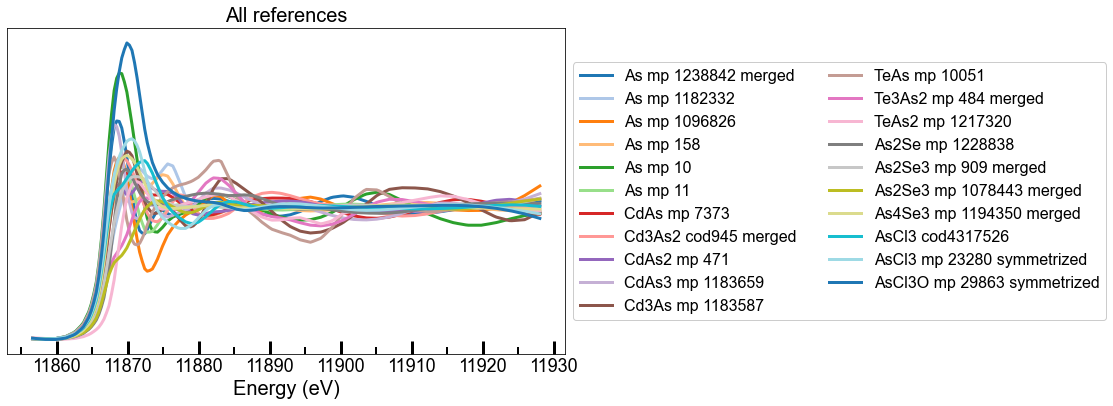

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'#\nE = {Energy[np.argmax(ref)]}'
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
plt.title("All references", fontsize=20)
format_axis(ax, ticks=(5,10))
plt.show()

# PCA Analysis

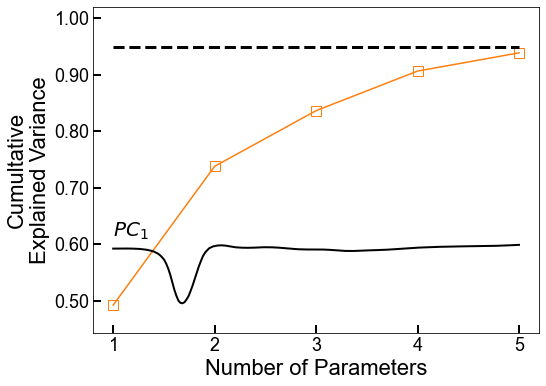

In [24]:
make_scree_plot(Refs)    

# Generate dataset using linear combinations of reference spectra

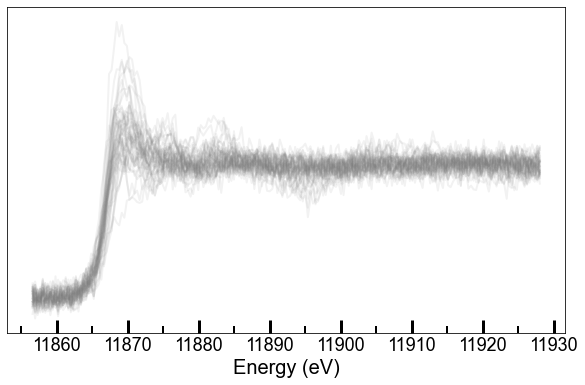

In [25]:
kwargs = {'N': 500, 'scale': 0.05, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': 0.05, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

plot_spectra(Energy, data, mod=10, alpha=0.1)

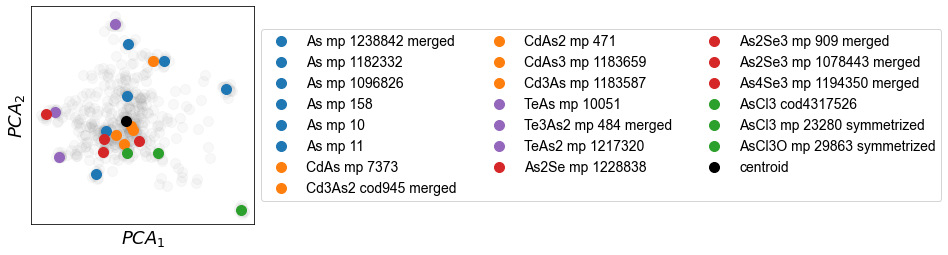

In [26]:
two_dimensional_visualization(data, Refs, data_columns, ncol=3, method='PCA', fontsize=18)

# Augment dataset using a GAN

In [48]:
mlmodels = reload(mlmodels)

In [49]:
latent_dim = 15
# wgan = mlmodels.WGAN(Refs, latent_dim)
args = [Refs, latent_dim]
wgan = mlmodels.WGAN_GP(0.1, *args)

kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.1 , 'training': False}
real_data, real_coeffs = generate_linear_combos(Refs, **kwargs)
fake_data, fake_coeffs = wgan.generate_fake_samples(6, training=False)

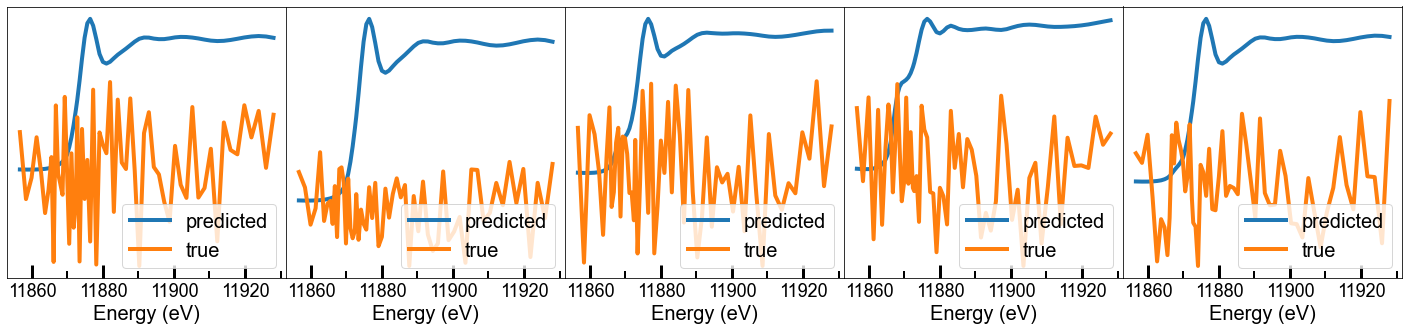

mean absolute error: 0.7634401166242417


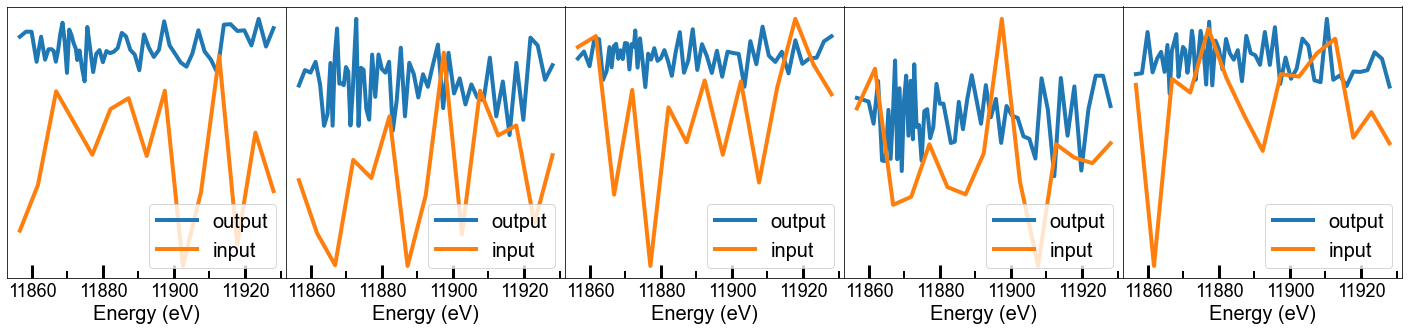

In [50]:
plot_reconstructions(fake_data, fake_coeffs, 5, Energy, Refs)
wgan.plot_input_output(5, Energy, Refs)

Discriminator Loss is the main convergence metric for GANs. Discriminator loss is the (negative) approximation of the Wasserstein distance so it should converge to zero (can't tell the different between real and fake images).

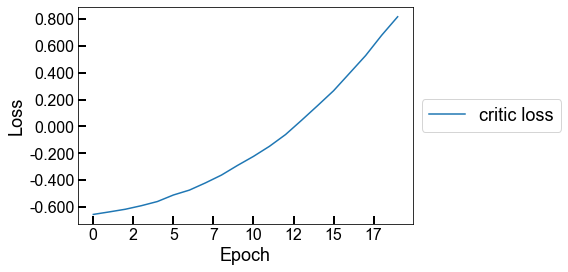

In [51]:
wgan.train(n_epochs=20, n_batch=128)

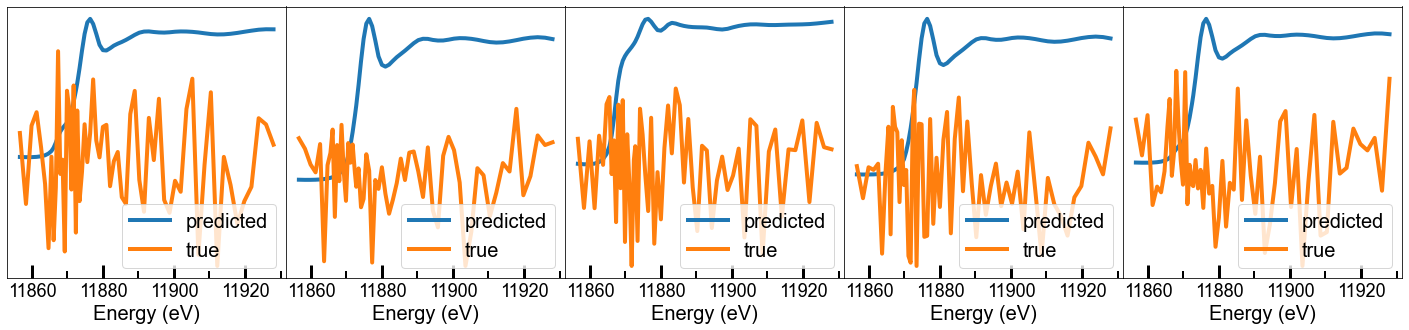

mean absolute error: 0.8227665471810036


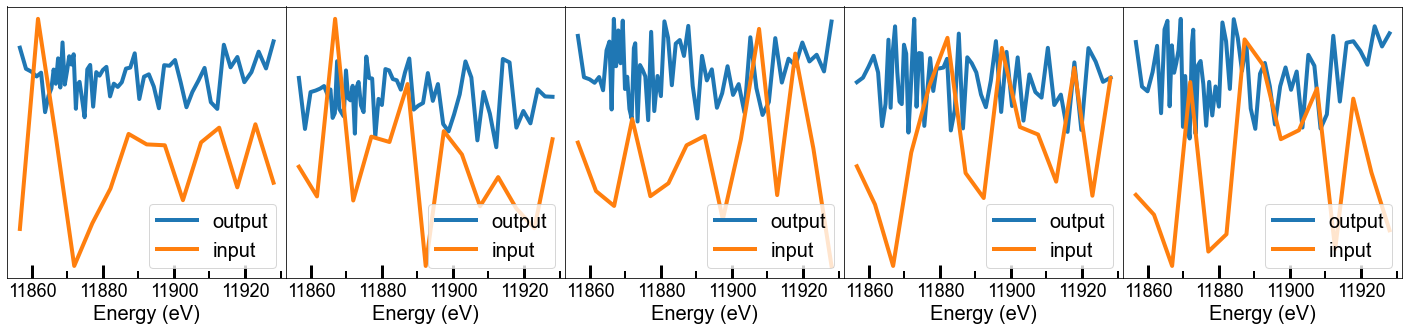

In [52]:
fake_data, fake_coeffs = wgan.generate_fake_samples(5, training=False)
noise = wgan._generate_latent_points(5)
plot_reconstructions(fake_data, fake_coeffs, 5, Energy, Refs)
wgan.plot_input_output(5, Energy, Refs)

# Initialize Selector and perform selection algorithm

### Some potential advancements:

1. Logistic regression and xgboost are models with feature importances that will work if the labels were one dimensional. A work around is using a RegressorChain or MultiOutputRegressor wrapper model.

2. Gaussian processes and other nonlinear models would work if permutation_importance worked as the importance_getter

e.g.

` def importance(model):`
    
 &emsp; &emsp; ` return permutation_importance(model, data, coeffs, scoring='neg_mean_squared_error')`
    
` importance_getter = importance`

These features can theoretically be implemented to improve the RFE algorithm.

In [11]:
energy_point_selector = reload(selector.energy_point_selector)
select = energy_point_selector.Selector(data, coeffs)

For a list of possible scoring criteria, see `sklearn.metrics.SCORERS.keys()`

In [13]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
n_points = [18]
Scores = []
Epts = []

for npts in n_points:
    print(f'\nNum points: {npts}\n-----------------------')
    scores = []
    epts = []
    for model in models:
        print(f'\n{model}:')
        select = energy_point_selector.Selector(data, coeffs)
        rfe, cvscore = select.select_energy_points(estimator=model, n_points=npts,
                                                   scoring='neg_root_mean_squared_error')
        energy_points = Energy[rfe.support_]
        epts.append(energy_points)
        scores.append(cvscore)
    Scores.append(scores)
    Epts.append(epts)

# Visualize Selected Energy Points

In [ ]:
nrows = len(n_points)
ncols = len(models)
fig, axes = plt.subplots(figsize=(ncols*5, nrows*5), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0, hspace=0.45)

for i, npts in enumerate(n_points):
    row_axes = axes[i]
    for energy_pts, model, score, ax in zip(Epts[i], models, Scores[i], row_axes):
        diff = 25
        ticks = (10, 20)
        visualize_energy_points((fig, ax), Energy, Refs,
                                energy_pts, ticks=ticks, label=model)
        text = ax.text(np.max(Energy) - diff, np.max(Refs)*0.5, f'RMSE:\n{-score:.3}',
                       ha="left", va="center", size=20)
    label = row_axes[0].set_ylabel(f'n = {npts}', fontsize=20)

# Model Selection

Variation for different datasets made with the same References.

In [8]:
energy_point_selector = reload(selector.energy_point_selector)

In [9]:
best_estimator = 'Random Forest'
best_n = 12
Is = []

reps = 30
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 1000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                               verbose=False, scoring='neg_root_mean_squared_error',
                                               n_estimators=30)
    energy_measurements = Energy[rfe.support_]
    indices = [i for i, e in enumerate(Energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

In [10]:
print(Is)

[[ 28  29  38  41  46  53  61  85  93 122 132 188]
 [ 28  38  40  47  51  62  92 122 132 149 173 197]
 [ 29  36  38  46  49  56  63  92 121 131 173 199]
 [ 27  36  41  47  53  57  68 119 128 150 172 199]
 [ 29  37  40  45  46  52  62 122 134 149 171 199]
 [ 29  37  40  47  54  62  65  87 119 147 173 199]
 [ 26  37  40  45  46  50  55  58  95  97 122 177]
 [ 30  36  40  45  47  51  61  64  91 120 148 199]
 [ 27  38  41  46  53  57  71  95 122 148 174 199]
 [ 31  37  40  47  52  61  94 122 134 151 174 199]
 [ 29  36  41  47  49  57  62  95 121 130 182 198]
 [ 27  36  47  52  66  73  94 121 129 148 183 197]
 [ 27  37  40  46  47  56  63  71 122 132 148 199]
 [ 30  36  40  46  47  55  61  94 121 148 171 199]
 [ 28  31  36  42  47  53  58  76 122 130 148 199]
 [ 29  34  40  45  47  55  61  74  92 120 131 199]
 [ 28  36  40  46  47  52  62  83 122 132 150 199]
 [ 28  36  40  47  51  55  62  92 122 130 145 171]
 [ 29  36  41  47  53  62  94 120 122 132 185 199]
 [ 27  36  37  46  47  57  64  

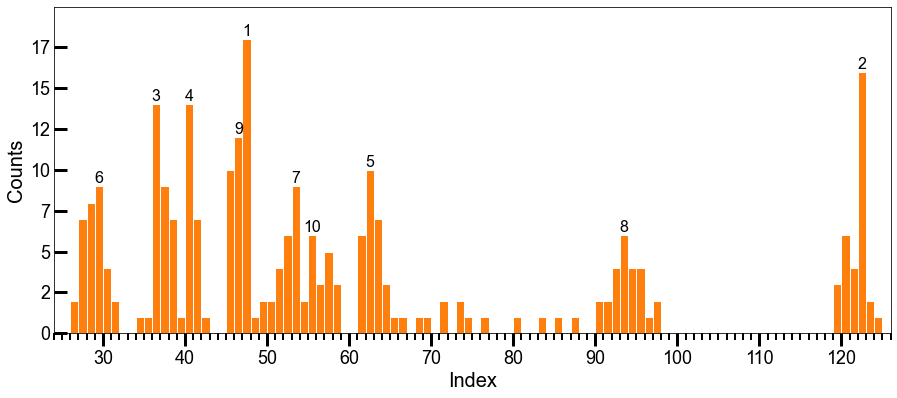

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
indices = [47, 122, 36, 40, 62, 29, 53, 93, 46, 55]
labels = np.arange(1, len(indices) + 1)
label_map = {idx: label for idx, label in zip(indices, labels)}
histogram((fig, ax), Is.reshape(-1), bins=Refs.shape[1] + 1, ticks=(1, 10),
           label_map=label_map)
plt.xlim(24, 126)
ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=18)
plt.savefig('Figures/histogram_of_importances_noise_1_percent_interpolated_cutoff.png', dpi=800, transparent=True)

`best_estimator = 'Random Forest'`

`best_n = 12`

`dropout': 0.9`

### Noise = 5%

`n_estimators=30`

`indices = [14, 10, 15, 13, 24, 30, 20, 18, 21, 40]`

### Noise = 3%:

`n_estimators=30`                                                                            

`indices = [15, 13, 22, 9, 24, 31, 41, 18, 20, 27]`

### Noise = 1%:

`n_estimators = 2`

`indices = [14, 24, 46, 21, 9, 18, 30, 33, 44, 50, 54, 27, 35, 42]`

`n_estimators = 50`

`indices = [14, 46, 24, 9, 50, 44, 21, 27, 30, 33, 54, 18, 35, 42]`

#### Interpolated to 200 energy points:

`n_estimators = 30`

`cutoff = + 45 eV`

`indices = [47, 122, 36, 40, 62, 29, 53, 93, 46, 55]`

## Validating energy points

In [14]:
kwargs = {'N': 1000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 500, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [15]:
best_estimator = 'Linear Regression'
best_n = 12

select = energy_point_selector.Selector(data, coeffs)
rfe, cvscore = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                           scoring='neg_root_mean_squared_error')
energy_measurements = Energy[rfe.support_]
indices = [i for i, e in enumerate(Energy) if e in energy_measurements]

Score: -0.018 (0.000)


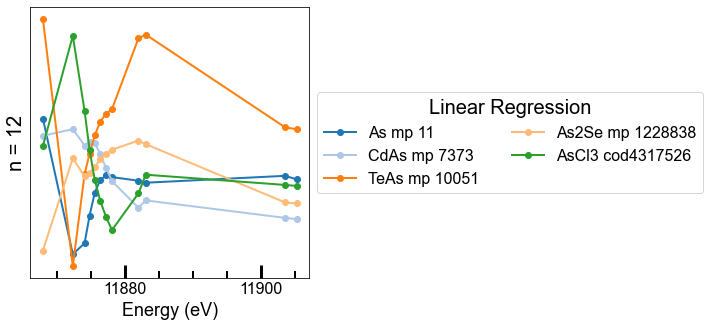

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

diff = 11.8
diff = -2
ticks = (5, 20)
fontsize = 20

n = Refs.shape[0]
ele_to_idx_map = {'Cd': 2, 'Te': 8, 'Se': 6, 'Cl': 4, 'exp': 1, 'As': 0}
for i, ref in enumerate(Refs[:, indices]):
    label = data_columns[i]
    for key in ele_to_idx_map.keys():
        if key in label:
            j = ele_to_idx_map[key]
            break
    if n < 20:
        c = i
    else:
        c = j
    color = plt.cm.tab20(c)  
    ax.plot(Energy[indices], ref, 'o-', linewidth=2, c=color, label=label)

    format_axis(ax, ticks=ticks, fontsize=fontsize-2)
ax.legend(fontsize=fontsize-4, loc='center left', bbox_to_anchor=(1., .5),
         title=f'{best_estimator}', title_fontsize=fontsize, ncol=2)
label = ax.set_ylabel(f'n = {best_n}', fontsize=20)

In [25]:
energy_measurements = [Energy[i] for i in indices]

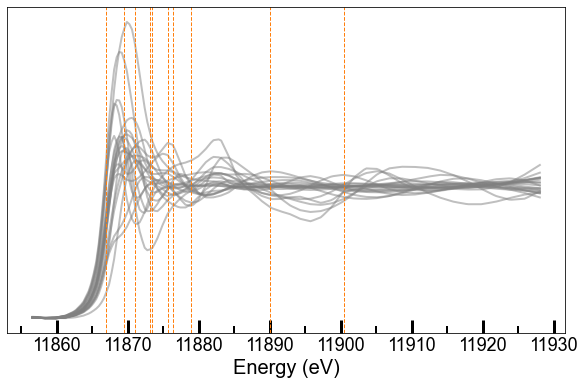

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    ax.plot(Energy, ref, '-', linewidth=2, c='gray', alpha=0.5)
format_axis(ax)

for energy in energy_measurements:
    ax.axvline(energy, c=plt.cm.tab20(2), linestyle='--', linewidth=1.)

plt.show()

## Validate Regression Task using energy subset

Train and score each regression model using the selected energy subset to predict the linear combination coefficients.

In [315]:
ref_coeff = np.identity(Refs.shape[0])
m, x, y, z = 'Model', 'Train', 'Validation', 'Refs'
print(f'{m:45s}| {x:20s}| {y:20s}| {z:20s} ')
print('-'*105)
    
for reg in [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(),
            GaussianProcessRegressor(), MLPRegressor(hidden_layer_sizes=(40, 40)),
            Lasso()]:
    
    reg.fit(data[:, indices], coeffs)
    
    x = f'{reg.score(data[:, indices], coeffs):.4f}'
    y = f'{reg.score(test_data[:, indices], test_coeffs):.4f}'
    z = f'{reg.score(Refs[:, indices], ref_coeff):.4f}'
    print(f'{str(reg):45s}| {x:20s}| {y:20s}| {z:20s} ')

Model                                        | Train               | Validation          | Refs                 
---------------------------------------------------------------------------------------------------------
LinearRegression()                           | 0.3428              | -0.1874             | 0.3654               
RandomForestRegressor()                      | 0.9711              | 0.6737              | 1.0000               
DecisionTreeRegressor()                      | 1.0000              | 0.0834              | 1.0000               
GaussianProcessRegressor()                   | 0.9003              | 0.6286              | 0.9963               
MLPRegressor(hidden_layer_sizes=(40, 40))    | 0.2977              | -0.0544             | 0.3356               
Lasso()                                      | 0.0000              | -0.1274             | -0.0001              


` The Random Forest Regressor performed the best and subsequent analysis should use this model.`

## Test dataset
Test on experimental data.

In [18]:
kwargs = {'N': 10000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 100, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [19]:
reg = LinearRegression()
reg.fit(data[:, indices], coeffs)

y_pred = reg.predict(test_data[:, indices])
print(f'Add to one? {np.sum(y_pred, axis=1).all()}')

for metric in ["mean_squared_error", "explained_variance_score"]:
    test_score = eval(metric)(y_pred, test_coeffs)
    metric = metric.replace('_', ' ')
    print(f'{metric}: {test_score:.5f}')

Add to one? True
mean squared error: 0.00097
explained variance score: 0.99333


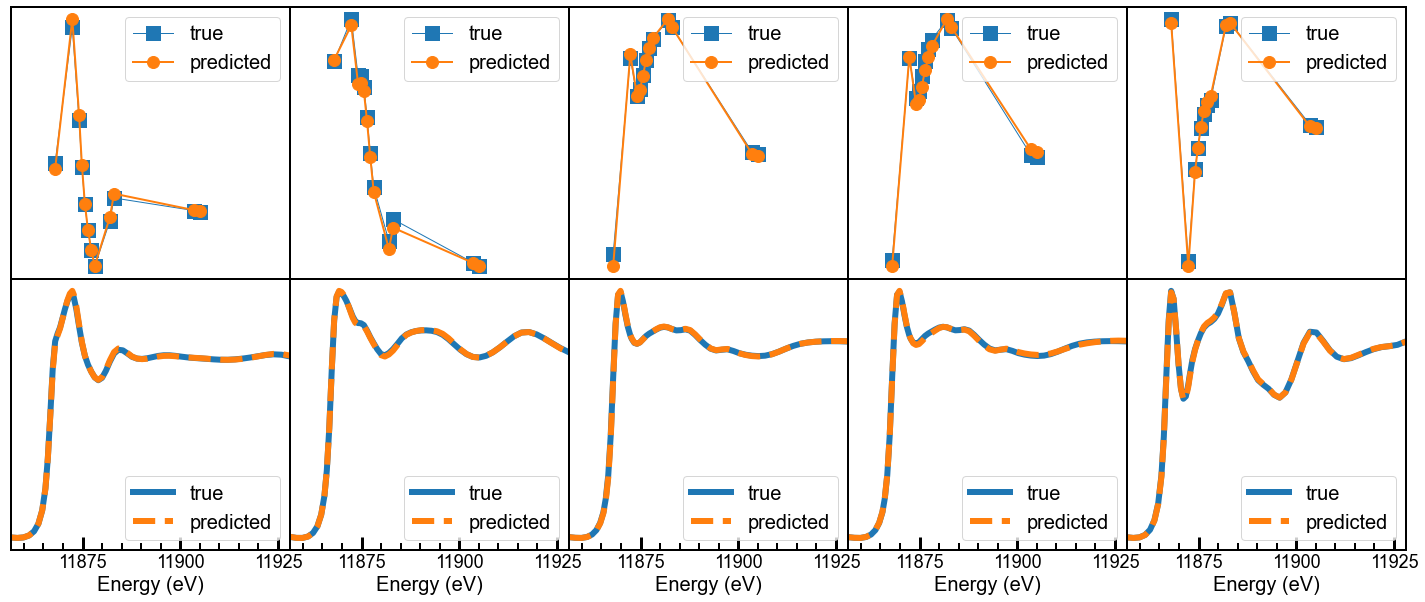

In [75]:
m = 5
fig, axes = plt.subplots(figsize=(5*m, 5*2), ncols=m, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0)

for j, show_subset in enumerate([True, False]):
    for i in range(m):
        pred = Refs.T @ y_pred[i]
        true = Refs.T @ test_coeffs[i]
        ax = axes[j][i]

        if show_subset:
            ax.plot(Energy[indices], true[indices], 's-', linewidth=1, c=plt.cm.tab20(0),
                    markersize=12, markeredgewidth=3, label='true')
            ax.plot(Energy[indices], pred[indices], 'o-', linewidth=2, c=plt.cm.tab20(2),
                    markersize=12, label='predicted')
            loc = 1
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.plot(Energy, true, '-', linewidth=6, c=plt.cm.tab20(0), label='true')
            ax.plot(Energy, pred, '--', linewidth=6, c=plt.cm.tab20(2), label='predicted')
            loc = 4
            format_axis(ax, ticks=(5, 25), fontsize=20)
        
        ax.legend(fontsize=20, loc=loc)
            
        set_spine_width(ax, width=2)
        ax.set_xlim(min(Energy), max(Energy))
plt.show()

# Compare to Random Energies

In [97]:
noise = 0.05
kwargs = {'N': 1000, 'scale': noise, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': noise, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)
select = energy_point_selector.Selector(data, coeffs)

In [98]:
baseline = []
metric = 'explained_variance_score'
for i, d in enumerate(data):
    c = coeffs[i]
    p = Refs.T @ c
    p = p - np.min(p)
    score = eval(metric)(d, p)
    baseline.append(score)
baseline = np.array(baseline)
mu = np.average(baseline)
sig2 = np.std(baseline)
print(f'{mu} +/- {sig2}')

0.9824379109654141 +/- 0.0044945023734593095


In [89]:
metrics = []
ns = np.arange(4, 27, 2)
for best_n in ns:
    for mode in ['RFE', 'random']:
        if mode == 'RFE':
            rfe, cvscore = select.select_energy_points(estimator='randomforest', n_points=best_n,
                                                       scoring='neg_root_mean_squared_error', verbose=False)
            energy_measurements = Energy[rfe.support_]
            indices = [i for i, e in enumerate(Energy) if e in energy_measurements]
        else:
            indices = np.random.randint(0, high=len(Energy), size=(best_n,))
        
        reg = RandomForestRegressor()
        reg.fit(data[:, indices], coeffs)
        
        pred_coeff = reg.predict(test_data[:, indices])
        
        cv_scores = []
        m = 10
        for i in range(m):
            pred_spectra = Refs.T @ pred_coeff[i]
            pred_spectra = pred_spectra - np.min(pred_spectra)
            true_spectra = test_data[i]
        
            temp_score = eval(metric)(pred_spectra, true_spectra)
            cv_scores.append(temp_score)
        score = np.average(cv_scores)  
#         print(f'{mode}: n = {best_n}: score = {score}')
        metrics.append(score)
metrics = np.array(metrics).reshape(-1, 2)

In [ ]:
x = np.array(ns, dtype=int)
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(x, metrics[:, 0], 'o-', linewidth=2, label='RFE')
plt.plot(x, metrics[:, 1], 'o-', linewidth=2, label='Random')

ax.axhline(y=mu, c='k', linestyle='--', linewidth=2.)
xlim = ax.get_xlim()
fill = np.linspace(xlim[0], xlim[1], 2)
plt.fill_between(fill, mu - 3*sig2, y2=mu + 3*sig2, fc='gray', alpha=0.5)
plt.xlim(xlim)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=16)
ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=16)
ax.set_xlabel('n', fontsize=18)
metric = metric.replace('_', ' ')
ax.set_ylabel(f'{metric}', fontsize=18)
ax.tick_params(direction='in', width=2, length=8, which='major')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.legend(fontsize=18)
plt.show()

# Results

In [97]:
I_choices = [[], [], []]
I_noises = [0.01, 0.03, 0.05]
I_choices[0] = [14, 24, 46, 21,  9, 18, 30, 33, 44, 50]
I_choices[1] = [15, 13, 22,  9, 24, 31, 41, 18, 20, 27]
I_choices[2] = [14, 10, 15, 13, 24, 30, 20, 18, 21, 40]

In [8]:
def get_mu_sig_of_recon(data, coeffs, Refs, metric='explained_variance_score'):
    baseline = []
    for i, d in enumerate(data):
        c = coeffs[i]
        p = Refs.T @ c
        p = p - np.min(p)
        score = eval(metric)(d, p)
        baseline.append(score)
    baseline = np.array(baseline)
    mu = np.average(baseline)
    sig = np.std(baseline)
    return mu, sig

In [113]:
def get_metrics(indices, data, coeffs, test_data, test_coeffs, 
                Refs, metric='explained_variance_score', verbose=True):
    metrics = []
    for i in range(len(indices)):
        idx = indices[:i + 1]

        reg = RandomForestRegressor()
        reg.fit(data[:, idx], coeffs)

        pred_coeff = reg.predict(test_data[:, idx])

        cv_scores = []
        m = 10
        for j in range(m):
            pred_spectra = Refs.T @ pred_coeff[j]
            pred_spectra = pred_spectra - np.min(pred_spectra)
            true_spectra = test_data[j]

            temp_score = eval(metric)(pred_spectra, true_spectra)
            cv_scores.append(temp_score)
        score = np.average(cv_scores)  
        if verbose:
            print(f' n = {i}: score = {score}')
        metrics.append(score)
    return np.array(metrics)

In [132]:
def plot_recon_variance(plot, metrics, mu, sig, label=None, ylim=None,
                        metric='explained_variance_score'):
    fig, ax = plot
    x = np.arange(len(metrics))
    
    ax.plot(x, metrics, 'o-', linewidth=2, label=label)

    xlim = ax.get_xlim()
    fill = np.linspace(xlim[0], xlim[1], 2)
    ax.fill_between(fill, mu - sig, y2=mu + sig, fc='gray', alpha=0.4)
    ax.axhline(y=mu, c='k', linestyle='--', linewidth=2., alpha=0.5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=16)
    ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int) + 1, fontsize=16)
    ax.set_xlabel('n', fontsize=18)
    metric = metric.replace('_', ' ')
    label = label.replace('_', ' ')
    ax.set_ylabel(f'{metric}', fontsize=18)
    ax.tick_params(direction='in', width=2, length=8, which='major')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    x = (xlim[1] - xlim[0])*0.5 + xlim[0]
    y = (ylim[1] - ylim[0])*0.5 + ylim[0]

In [133]:
data_noises = [0.01, 0.03, 0.05]
Metrics = [list() for i in data_noises]
Mus = [list() for i in data_noises]
Sigs = [list() for i in data_noises]
n = len(I_choices)
m = len(data_noises)

for i, indices in enumerate(I_choices):
    i_noise = I_noises[i]
    for j, data_noise in enumerate(data_noises):
        print(i, j, end='\r')
        # get data
        kwargs = {'N': 500, 'scale': data_noise, 'dropout': 0.9, 'training': False}
        train_data, train_coeffs = generate_linear_combos(Refs, **kwargs)
        kwargs = {'N': 50, 'scale': data_noise, 'dropout': 0.9, 'training': False}
        test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)
        # get results
        metrics = get_metrics(indices, train_data, train_coeffs, test_data, test_coeffs, 
                              Refs, verbose=False)
        mu, sig = get_mu_sig_of_recon(train_data, train_coeffs, Refs)
        Metrics[j].append(metrics)
        Mus[i].append(mu)
        Sigs[i].append(sig)

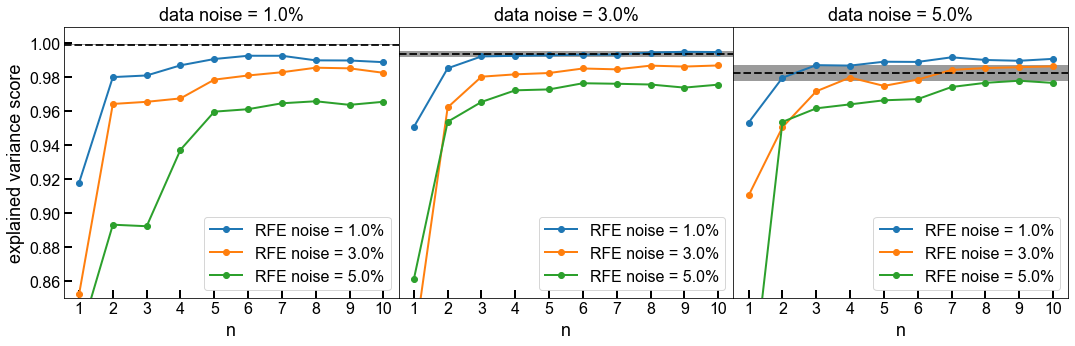

In [135]:
fig, axes = plt.subplots(figsize=(n*6, 5), nrows=1, ncols=m)
plt.subplots_adjust(wspace=0.)

for i, indices in enumerate(I_choices):
    i_noise = I_noises[i]
    for j, data_noise in enumerate(data_noises):      
        ax = axes[j]
        metrics = Metrics[i][j]
        mu = np.average([Mus[k][j] for k in range(len(Mus))])
        sig = np.average([Sigs[k][j] for k in range(len(Sigs))])
        label = f'RFE noise = {i_noise*100:.1f}%'
        plot_recon_variance((fig, ax), metrics, mu, sig, label=label, ylim=(0.85, 1.01))
        if j != 0:
            ax.set_yticks([])
            ax.set_ylabel(None)
        ax.set_title(f'data noise = {data_noise*100:.1f}%', fontsize=18)
plt.savefig(f'Figures/variance_score_noise_comparison.png', dpi=800, transparent=True)

# Data I/O

In [27]:
indices = [47, 122, 36, 40, 62, 29, 53, 93, 46, 55]
resolution = Energy[1] - Energy[0]
print(f"resolution: {resolution}")
energy_measurements = np.array(Energy[indices])
whiteline = Energy[np.argmax(24)] # AS2O3 0112 ASU exp standard
delta_Es = np.around(energy_measurements - whiteline, decimals=2)

resolution: 0.3588341708546068


In [28]:
print(delta_Es)

[16.87 43.78 12.92 14.35 22.25 10.41 19.02 33.37 16.51 19.74]


In [30]:
clipped_delta_Es = delta_Es[delta_Es < 45]
clipped_energy_measurements = np.around(energy_measurements[delta_Es < 45], decimals=2)
clipped_delta_Es

array([16.87, 43.78, 12.92, 14.35, 22.25, 10.41, 19.02, 33.37, 16.51,
       19.74])

In [31]:
data = np.array([clipped_energy_measurements, clipped_delta_Es]).T
df = pd.DataFrame(data, columns=['Energy measurement', 'Delta E'])
df.index = df.index + 1
df.head()

,Energy measurement,Delta E
1,11873.48,16.87
2,11900.39,43.78
3,11869.53,12.92
4,11870.97,14.35
5,11878.86,22.25


In [32]:
filename = 'energy_measurements_interpolated.csv'
comments = f"Expected whiteline energy for AS2O3: {whiteline}\n"
with open(filename, 'w') as f:
    f.writelines(comments)
    df.to_csv(f, columns=df.columns)